In [1]:
import numpy as np
from numpy import pi, exp, shape, array, r_, c_, dot, nan, inf, where, sqrt, arange
from numpy import log, log10, logspace, zeros

import scipy.io
from scipy.integrate import quad, quadrature, romberg
from scipy.optimize import fmin, minimize
from scipy.stats import scoreatpercentile
from scipy.integrate import ode, odeint

from matplotlib import rc
from matplotlib.pylab import *
from matplotlib.mlab import find
#import random, time, os, psutil, datetime, sys

In [2]:
np.set_printoptions(precision=3, edgeitems=8, linewidth=150)

# Introduction

We are building upon the Lotka-Volterra predator prey model outlined in Sahoo et al. to investigate the contribution of CAR T cell signaling to exhaustion. Our model improves upon the Sahoo model in a few key aspects: 

1) By accounting for the internal signaling dynamics of the T cell we can introduce feedback loops

2) We distinguish between several states that our T cells can occupy: resting, active, and exhausted

Not sure what to call this model... I think it should still be considered a Lotka-Volterra model but it includes some more complex dynamics

## Initialize the ODE model

Define a vector x that contains all the species in the model: x = [CC, TC, CAR, aCAR] (CC = cancer cell, TC = T cell).

We separate the model into three possible states:

1) aCAR < t1: T cells are resting and die at a basal rate, don't proliferate, and don't kill

2) t1<= aCAR <=t2: T cells are active and don't die (may need to revisit this), proliferate, and kill

3) aCAR > t2: T cells are exhausted and die at an accelerated rate, don't proliferate, and don't kill

In [6]:
#CC = x[0]
#TC = x[1]
#CAR = x[2]
#aCAR = x[3]

def model1(x, t, t1, t2, a, k_d, g_i, g_a, k_a, rho, K, K1, theta_r, K2, theta_e):
    tCAR = x[2]+x[3]
    #Resting Cells
    if x[3]<(t1*tCAR):
        return np.array([
            rho*x[0] * (1 - x[0]/K),
            -theta_r*x[1],
            a + k_d*x[3] - x[2] * (k_a*x[0] + g_i),
            k_a*x[2]*x[0] - x[3]*(k_d + g_a)
        ])
    
    #Acitvated Cells
    if (t1*tCAR)<=x[3]<=(t2*tCAR):
        return np.array([
            rho*x[0] * (1 - x[0]/K) - K1*x[0]*x[1],
            K2*x[1],
            a + k_d*x[3] - x[2] * (k_a*x[0] + g_i),
            k_a*x[2]*x[0] - x[3]*(k_d + g_a)
        ])
    
    #Exhausted Cells
    if x[3]>(t2*tCAR):
        return np.array([
            rho*x[0] * (1 - x[0]/K),
            -theta_e*x[1],
            a + k_d*x[3] - x[2] * (k_a*x[0] + g_i),
            k_a*x[2]*x[0] - x[3]*(k_d + g_a)
        ])

In [22]:
#Initialize a vector for the simulation time
tt1 = arange(0,1,1e-2)

#Set parameters for the model

t1 = 0.05 #Lower bound for T cell activation
t2 = 0.5 #Upper bound for T cell activation
a = 1e2 #CAR production rate
k_d = 0.01 #Decay rate of active CAR to inactive CAR
g_i = 0.001 #inactive CAR degradation rate
g_a = 0.002 #active CAR degradation rate
k_a = 0.01 #activation rate of CAR
rho = 3 #Logistic growth rate
K = 1e6 #Carrying capacity
K1 = 1 #Killing rate
theta_r = 0.001 #T cell resting death rate
K2 = 1 #T cell active proliferation rate
theta_e = 0.01 #T cell exhausted death rate

#Set initial conditions for the model
x0 = [1e3, 1e2, 1e6, 0]

In [23]:
#Solve system of equations
yy1 = odeint(model1, x0, tt1, args = (t1, t2, a, k_d, g_i, g_a, k_a, rho, K, K1, theta_r, K2, theta_e), atol = 1e-6, rtol = 1e-5)

In [24]:
yy1

array([[ 1.000e+03,  1.000e+02,  1.000e+06,  0.000e+00],
       [ 6.299e+02,  1.005e+02,  9.131e+05,  8.692e+04],
       [ 2.364e+02,  1.015e+02,  8.771e+05,  1.229e+05],
       [ 8.784e+01,  1.025e+02,  8.640e+05,  1.359e+05],
       [ 3.230e+01,  1.036e+02,  8.593e+05,  1.407e+05],
       [ 1.176e+01,  1.046e+02,  8.575e+05,  1.424e+05],
       [ 4.234e+00,  1.056e+02,  8.569e+05,  1.430e+05],
       [ 1.509e+00,  1.067e+02,  8.567e+05,  1.433e+05],
       [ 5.321e-01,  1.078e+02,  8.566e+05,  1.433e+05],
       [ 1.856e-01,  1.089e+02,  8.566e+05,  1.433e+05],
       [ 6.404e-02,  1.100e+02,  8.566e+05,  1.433e+05],
       [ 2.186e-02,  1.111e+02,  8.566e+05,  1.433e+05],
       [ 7.377e-03,  1.122e+02,  8.566e+05,  1.433e+05],
       [ 2.462e-03,  1.133e+02,  8.566e+05,  1.433e+05],
       [ 8.124e-04,  1.144e+02,  8.566e+05,  1.433e+05],
       [ 2.650e-04,  1.156e+02,  8.566e+05,  1.432e+05],
       [ 8.540e-05,  1.168e+02,  8.566e+05,  1.432e+05],
       [ 2.724e-05,  1.179e+02,

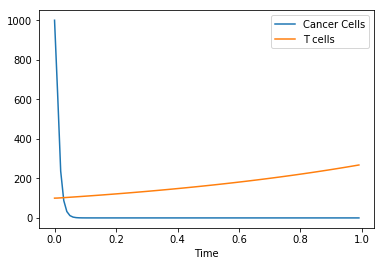

In [25]:
xlabel = ['Cancer Cells', 'T cells', 'CAR', 'aCAR']

for i in arange(2):
    plt.plot(tt1, yy1[:,i], label = xlabel[i])
    plt.legend()
    plt.xlabel('Time')

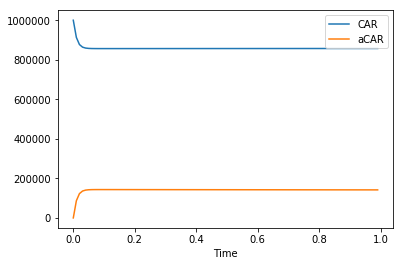

In [26]:
for i in arange(2):
    plt.plot(tt1, yy1[:,i+2], label = xlabel[i+2])
    plt.legend()
    plt.xlabel('Time')